In [1]:
import requests
import pandas as pd
import phe as paillier
import time
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from lime.lime_text import LimeTextExplainer
import numpy as np
from sklearn.linear_model import LogisticRegression

# Reading E-BANKING PHSIHING URLS FROM PHISHTANK

In [2]:
df = pd.read_csv('phishtank_urls.csv')
df.head()

,Urls,Label
0,https://point-relaisfrance.com/,1
1,https://point-relaisfrance.com/pac/calcul.php,1
2,https://allegrolokalnie.pl-kategorie-inne-120.icu,1
3,https://download-wallett-home.webflow.io,1
4,https://gasimoldiutarfditafidari.cfolks.pl/a/a...,1


# Reading Legit urls downloaded from https://majestic.com/reports/majestic-million

In [3]:
#let' load the dataset

# Load the CSV into a DataFrame
df2 = pd.read_csv('majestic_million.csv')

# Inspect the first few rows to ensure we're getting the right column
df2.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs
0,1,1,google.com,com,479230,2137257,google.com,com,1,1,478850,2136357
1,2,2,facebook.com,com,466195,2207970,facebook.com,com,2,2,465854,2207039
2,3,3,youtube.com,com,423723,1849219,youtube.com,com,3,3,423457,1848536
3,4,4,twitter.com,com,390436,1635184,twitter.com,com,4,4,390233,1634745
4,5,5,instagram.com,com,372749,1637015,instagram.com,com,5,5,372538,1636332


In [4]:
#Extracting the first 10,000 legitimate urls
top_urls = df2.iloc[:10000, 2].tolist()

# Create a DataFrame with URLs and labels (0 for legitimate)
data = {
    'Urls': top_urls,
    'Label': [0] * len(top_urls)  # Label 0 for legitimate URLs
}

# Convert the data to a DataFrame
df_legit = pd.DataFrame(data)


In [5]:
df_legit

,Urls,Label
0,google.com,0
1,facebook.com,0
2,youtube.com,0
3,twitter.com,0
4,instagram.com,0
...,...,...
9995,legal500.com,0
9996,childrenshealthdefense.org,0
9997,blogdigy.com,0
9998,thetyee.ca,0


# MERGING THE BOTH DATASET TOGETHER

In [6]:
final_data = pd.concat([df, df_legit], ignore_index=True)

In [7]:
final_data

,Urls,Label
0,https://point-relaisfrance.com/,1
1,https://point-relaisfrance.com/pac/calcul.php,1
2,https://allegrolokalnie.pl-kategorie-inne-120.icu,1
3,https://download-wallett-home.webflow.io,1
4,https://gasimoldiutarfditafidari.cfolks.pl/a/a...,1
...,...,...
19995,legal500.com,0
19996,childrenshealthdefense.org,0
19997,blogdigy.com,0
19998,thetyee.ca,0


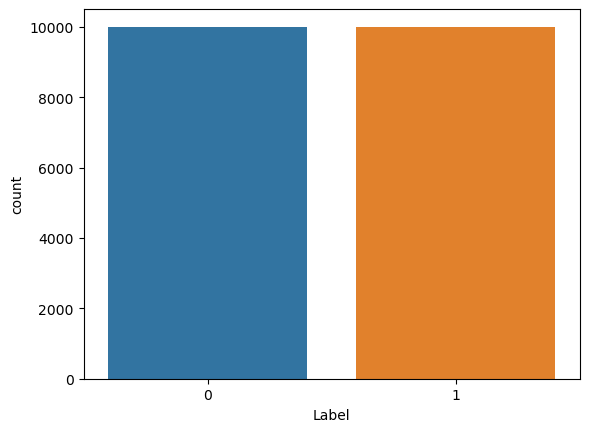

In [8]:
sns.countplot(x='Label', data=final_data)
plt.show()

# Data Preprocessing

In [9]:
Urls = final_data.drop( 'Label', axis=1)
y = final_data['Label']

In [10]:
Urls = final_data['Urls'].values.astype('U')

In [11]:
count_vect = CountVectorizer()
X = count_vect.fit_transform(Urls)

In [12]:
X

<20000x20241 sparse matrix of type '<class 'numpy.int64'>'
	with 74757 stored elements in Compressed Sparse Row format>

In [13]:
print('Vocabulary size: %d' % X.shape[1])

Vocabulary size: 20241


In [14]:
def timer():
    time0 = time.perf_counter()
    yield
    print('[elapsed time: %.2f s]' % (time.perf_counter() - time0))

In [15]:
class Our_Model:
    """
    Our Model Trains a Logistic Regression model on plaintext data, encrypts the model for remote use by USER-1 and USER-2,
    decrypts encrypted scores using the paillier private key.
    """

    def __init__(self):
        self.model = RandomForestClassifier()

    # Generate Public and Private Key Pairs
    # Public Key is used to Encrypt the Data, Private Key to Decrypt
    def generate_paillier_keypair(self, n_length):
        self.pubkey, self.privkey = paillier.generate_paillier_keypair(n_length=n_length)

    # Train the Model
    def fit(self, X, y):
        self.model = self.model.fit(X, y)

    # Make Predictions for Email "Spam/Not Spam"
    def predict(self, X):
        return self.model.predict(X)

    # Encypt the Coefficients for the Random Forest Equation
    # Weights can tell about the data, so Encrypt them
    # Equation: y = mX + b
    def encrypt_weights(self):
        coef = self.model.coef_[0, :]
        encrypted_weights = [self.pubkey.encrypt(coef[i])
                             for i in range(coef.shape[0])]
        encrypted_intercept = self.pubkey.encrypt(self.model.intercept_[0])
        return encrypted_weights, encrypted_intercept

    # Decrypt the Scores for the Model
    def decrypt_scores(self, encrypted_scores):
        return [self.privkey.decrypt(s) for s in encrypted_scores]

In [16]:
# Now the USER-1 gets a trained model and trains on its own data all using Homomorphic Encryption.
class User_1:
    """
    USER-1/USER-2 are given the encrypted model trained by Our Model and the public key.

    Scores local plaintext data with the encrypted model, but cannot decrypt
    the scores without the private key held by Our Model.
    """

    def __init__(self, pubkey):
        self.pubkey = pubkey

    # Set Initial Values of Coefficients
    def set_weights(self, weights, intercept):
        self.weights = weights
        self.intercept = intercept

    # Compute the Prediction Scores for the Model all while being totally Encrypted.
    def encrypted_score(self, x):
        """Compute the score of `x` by multiplying with the encrypted model,
        which is a vector of `paillier.EncryptedNumber`"""
        score = self.intercept
        _, idx = x.nonzero()
        for i in idx:
            score += x[0, i] * self.weights[i]
        return score

    # Get the Evaluation Scores for the Model
    def encrypted_evaluate(self, X):
        return [self.encrypted_score(X[i, :]) for i in range(X.shape[0])]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Now firstly Our Model Generates the Public and Private Keys
print("Generating Paillier Public Private Keypair")
our_model = Our_Model()
# NOTE: using smaller keys sizes wouldn't be cryptographically safe
our_model.generate_paillier_keypair(n_length=1024)


Generating Paillier Public Private Keypair


In [19]:
print("Training Initial E-banking Phishing Classifier")
#with timer() as t:
our_model.fit(X_train, y_train)

Training Initial E-banking Phishing Classifier


# Model Evaluation

In [20]:
print("Our Model's Classification on Test Data.")
#with timer() as t:
error = np.mean(our_model.predict(X_test) != y_test)
print("Error {:.3f}".format(error))

Our Model's Classification on Test Data.
Error 0.000


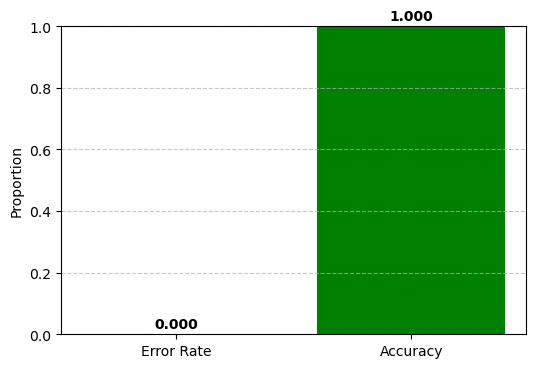

In [21]:
 accuracy = 1 - error

# Plotting
labels = ['Error Rate', 'Accuracy']
values = [error, accuracy]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['red', 'green'])
plt.ylim(0, 1)
plt.ylabel('Proportion')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the values on bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')

plt.show()

In [25]:
y_pred = our_model.predict(X_test)

In [26]:
# Customized Classification Report
target_names = ['Legitimate Banking URLs (0)', 'E-Banking Phishing URLs (1)']
print("Customized Classification Report For Random Forest Classifier:")
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

Customized Classification Report For Random Forest Classifier:
                             precision    recall  f1-score   support

Legitimate Banking URLs (0)      1.000     0.999     1.000      1981
E-Banking Phishing URLs (1)      1.000     1.000     1.000      2019

                   accuracy                          1.000      4000
                  macro avg      1.000     1.000     1.000      4000
               weighted avg      1.000     1.000     1.000      4000



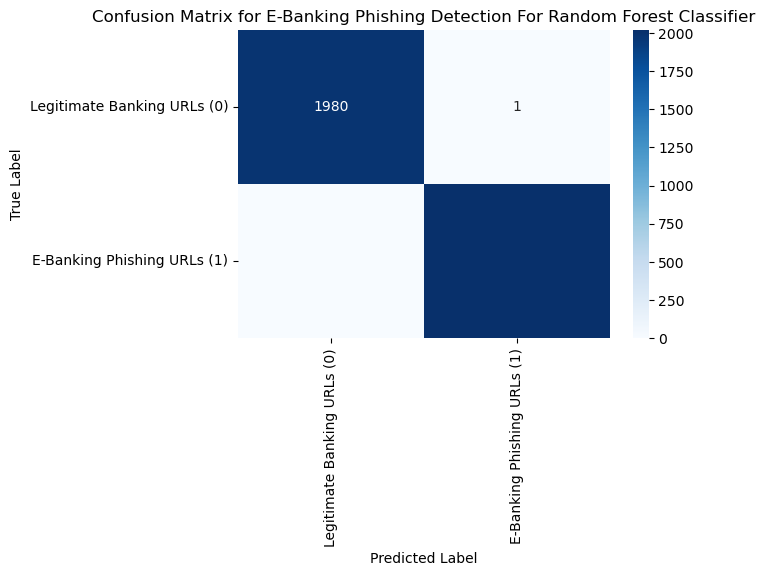

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for E-Banking Phishing Detection For Random Forest Classifier')
plt.show()

# Privacy preservation With Random Forest

In [ ]:
class PrivacyPreservingRandomForest:
    def __init__(self, pubkey, privkey=None):
        self.model = RandomForestClassifier(n_estimators=10, random_state=42)
        self.pubkey = pubkey
        self.privkey = privkey

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def encrypted_predict(self, X_enc):
        encrypted_preds = []
        for tree in self.model.estimators_:
            leaf_index = tree.apply(X_enc)
            encrypted_leaf_sum = self.pubkey.encrypt(sum(leaf_index))
            encrypted_preds.append(encrypted_leaf_sum)
        return encrypted_preds

    def decrypt_predictions(self, encrypted_preds):
        return [self.privkey.decrypt(p) for p in encrypted_preds]


In [ ]:
# Generate Paillier key pair
pubkey, privkey = paillier.generate_paillier_keypair(n_length=1024)

In [ ]:
pp_rf_model = PrivacyPreservingRandomForest(pubkey, privkey)
pp_rf_model.fit(X_train, y_train)

In [ ]:
# Evaluation on Test Data
print("Evaluating Random Forest Model on Test Data...")
y_pred = pp_rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing'], digits=3))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Random Forest With Homomorphic Encryption')
plt.show()

In [ ]:
# Feature Importance Plot
feature_importances = pp_rf_model.model.feature_importances_
feature_names = count_vect.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 20 Important Features in URL Phishing Detection')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Federated Learning With Logistics Regression

In [ ]:
class Our_Model1:
    """
    Our Model Trains a Logistic Regression model on plaintext data, encrypts the model for remote use by USER-1 and USER-2,
    decrypts encrypted scores using the paillier private key.
    """

    def __init__(self):
        self.model = LogisticRegression()

    # Generate Public and Private Key Pairs
    # Public Key is used to Encrypt the Data, Private Key to Decrypt
    def generate_paillier_keypair(self, n_length):
        self.pubkey, self.privkey = paillier.generate_paillier_keypair(n_length=n_length)

    # Train the Model
    def fit(self, X, y):
        self.model = self.model.fit(X, y)

    # Make Predictions for Email "Spam/Not Spam"
    def predict(self, X):
        return self.model.predict(X)

    # Encypt the Coefficients for the Logistic Regression Equation
    # Weights can tell about the data, so Encrypt them
    # Equation: y = mX + b
    def encrypt_weights(self):
        coef = self.model.coef_[0, :]
        encrypted_weights = [self.pubkey.encrypt(coef[i])
                             for i in range(coef.shape[0])]
        encrypted_intercept = self.pubkey.encrypt(self.model.intercept_[0])
        return encrypted_weights, encrypted_intercept

    # Decrypt the Scores for the Model
    def decrypt_scores(self, encrypted_scores):
        return [self.privkey.decrypt(s) for s in encrypted_scores]

In [ ]:
# Now firstly Our Model Generates the Public and Private Keys
print("Generating Paillier Public Private Keypair")
logistic_model = Our_Model1()
# NOTE: using smaller keys sizes wouldn't be cryptographically safe
logistic_model.generate_paillier_keypair(n_length=1024)


In [ ]:
print("Training Initial E-banking Phishing Classifier")
#with timer() as t:
logistic_model.fit(X_train, y_train)

# Evaluation of Logistic Regression

In [ ]:
print("logistic Model's Classification on Test Data.")
#with timer() as t:
error = np.mean(logistic_model.predict(X_test) != y_test)
print("Error {:.3f}".format(error))

In [ ]:
log_pred = logistic_model.predict(X_test)

In [ ]:
# Customized Classification Report
target_names = ['Legitimate Banking URLs (0)', 'E-Banking Phishing URLs (1)']
print("Customized Classification Report For Logistic Regression:")
print(classification_report(y_test, log_pred, target_names=target_names, digits=3))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, log_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for E-Banking Phishing Detection For Logistic Regression')
plt.show()

# Encrypting and Decrypting Logistic Regression Model

In [ ]:
print("Encrypting Trained Classifier before sending to USER-1/2")
#with timer() as t:
encrypted_weights, encrypted_intercept = logistic_model.encrypt_weights()

In [ ]:
# Confirming the Weights are Encrypted
print("Encrypted Weights: ", encrypted_weights)
print("Encrypted Intercept: ", encrypted_intercept)

In [ ]:
# USER-1 taking the encrypted model, weights and testing performance on it's own dataset
print("USER-1: Scoring on own data with logistic Model's Encrypted Classifier...")

In [ ]:
# Our Model sends the Public Keys to perform operations
user_1 = User_1(logistic_model.pubkey)

# USER-1 sets the model Hyperparameters to Our Model's Hyperparameter values
user_1.set_weights(encrypted_weights, encrypted_intercept)

In [ ]:

#with timer() as t:
encrypted_scores = user_1.encrypted_evaluate(X_test)

# Making Sure the Score is Encrypted
#print(encrypted_scores)
print("Decrypting USER-1/2's scores")

#with timer() as t:
scores = logistic_model.decrypt_scores(encrypted_scores)
error = np.mean(np.sign(scores) != y_test)
print(error)

In [ ]:
 accuracy = 1 - error

# Plotting
labels = ['Error Rate', 'Accuracy']
values = [error, accuracy]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['red', 'green'])
plt.ylim(0, 1)
plt.ylabel('Proportion')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the values on bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')

plt.show()